In [2]:
import numpy as np
import pandas as pd
import os 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
from torchmetrics.classification import BinaryAUROC 
import re
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.model_selection import train_test_split
train_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_final_without_ohe.csv")
test_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/test_final_without_ohe.csv")   

In [3]:
print(test_final.shape)
train_final.shape
test_final.columns

(48744, 495)


Index(['Unnamed: 0', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'AMT_CREDIT_SUM_DEBT_SUM_mean', 'AMT_CREDIT_SUM_DEBT_SUM_max',
       'AMT_CREDIT_SUM_DEBT_SUM_sum', 'CREDIT_ACTIVE_count',
       'CREDIT_ACTIVE_nunique', 'CREDIT_CURRENCY_count',
       'CREDIT_CURRENCY_nunique', 'CREDIT_TYPE_count', 'CREDIT_TYPE_nunique',
       'Bureau_flag'],
      dtype='object', length=495)

In [4]:
# hang=train_final.shape[0]
# print(hang)
# jie=hang//2
# train_final_head=train_final.iloc[:jie]
# train_final_last=train_final.iloc[jie+1:]
# train_final_head.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_final_without_ohe_1.csv")
# train_final_last.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_final_without_ohe_2.csv")

In [5]:
train_final.columns = [re.sub(r"[^a-zA-Z0-9_\-]","_",str(col)) for col in train_final.columns]
test_final.columns = [re.sub(r"[^a-zA-Z0-9_\-]","_",str(col)) for col in test_final.columns]
train_final.drop("Unnamed__0",axis=1,inplace=True)
test_final.drop("Unnamed__0",axis=1,inplace=True)

In [6]:
train_final.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_CREDIT_SUM_DEBT_SUM_mean,AMT_CREDIT_SUM_DEBT_SUM_max,AMT_CREDIT_SUM_DEBT_SUM_sum,CREDIT_ACTIVE_count,CREDIT_ACTIVE_nunique,CREDIT_CURRENCY_count,CREDIT_CURRENCY_nunique,CREDIT_TYPE_count,CREDIT_TYPE_nunique,Bureau_flag
0,100002,Cash loans,M and Others (new),N,Y,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,34721.195625,245781.0,277769.565,8.0,2.0,8.0,1.0,8.0,2.0,1
1,100003,Cash loans,F,N,N,270000.0,1293502.5,35698.5,1129500.0,Family,...,202500.000000,810000.0,810000.000,4.0,2.0,4.0,1.0,4.0,2.0,1
2,100004,Revolving loans,M and Others (new),Y,Y,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.000000,0.0,0.000,2.0,1.0,2.0,1.0,2.0,1.0,1
3,100006,Cash loans,F,N,Y,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100007,Cash loans,M and Others (new),N,Y,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.000000,0.0,0.000,1.0,1.0,1.0,1.0,1.0,1.0,1


In [7]:
build_score_cols=[c for c in train_final.columns if re.search(r"building",c,re.IGNORECASE)]
train_final=train_final.drop(columns=build_score_cols)
flag_cols=[c for c in train_final.columns if re.search(r"flag",c,re.IGNORECASE)]
print(len(flag_cols))
train_final[flag_cols].head()
train_final[flag_cols].dtypes
train_final[flag_cols]=train_final[flag_cols].astype(str)
id_target=["TARGET",'SK_ID_PREV','SK_ID_BUREAU','SK_ID_CURR']
cols=[c for c in train_final.columns if c not in id_target]
categorical_cols=train_final[cols].dtypes[(train_final[cols].dtypes==object) | (train_final[cols].dtypes=="str")].index.to_list()
numerical_cols  = [c for c in cols if c not in categorical_cols]
print(len(categorical_cols))
len(numerical_cols)

13
38


445

In [8]:
nunique_counts = train_final[cols].nunique()
# 筛选出唯一值数量 < 20 的列
low_count = nunique_counts[nunique_counts < 3]
low_count
for col  in low_count.index:
    if col not in categorical_cols:
        print(train_final[col].value_counts())
        print("_____________________")
        categorical_cols.append(col)
        if col in numerical_cols:
            numerical_cols.remove(col)
print(len(categorical_cols))
len(numerical_cols)


REG_REGION_NOT_WORK_REGION
0    291899
1     15612
Name: count, dtype: int64
_____________________
REG_CITY_NOT_LIVE_CITY
0    283472
1     24039
Name: count, dtype: int64
_____________________
LIVE_CITY_NOT_WORK_CITY
0    252296
1     55215
Name: count, dtype: int64
_____________________
DAYS_EMPLOYED_ANOM
0    252137
1     55374
Name: count, dtype: int64
_____________________
REC_Inquiries_Rate
0.0    307511
Name: count, dtype: int64
_____________________
alldocs_kurt
0.0    307511
Name: count, dtype: int64
_____________________
alldocs_skew
1.732051    270442
0.000000     37069
Name: count, dtype: int64
_____________________
alldocs_mean
0.333333    270442
0.000000     37069
Name: count, dtype: int64
_____________________
alldocs_sum
1    270442
0     37069
Name: count, dtype: int64
_____________________
alldocs_std
0.57735    270442
0.00000     37069
Name: count, dtype: int64
_____________________
AVG_NAME_CONTRACT_TYPE_count
1.0    291057
0.0     16454
Name: count, dtype: int64
__

403

In [9]:
if "SK_ID_CURR" in test_final.columns:
    print(111)
else:
    print(222)

111


In [10]:
df=train_final.copy()
target=train_final.TARGET
ids = test_final.SK_ID_CURR
#print(test_final.head())
train=df.drop(["SK_ID_CURR","TARGET"],axis=1)
test_final.drop(["SK_ID_CURR"],axis=1,inplace=True)

In [11]:
x_train,x_test,y_train,y_test=train_test_split(train,target,test_size = 0.10, random_state = 1008, stratify=target)

In [12]:
# 健壮性的标签编码格式
class RobustLabelEncoder:
    def __init__(self,min_obs=1):
        self.min_obs=min_obs
        self.mapper={}
    def fit(self,series):
        value_counts=series.value_counts()
        valid_cols=value_counts[value_counts>self.min_obs].index.tolist()
        # 构建映射表,从1开始映射
        self.mapper={val:i+1 for i,val in enumerate(valid_cols)}
        self.cate_dims=len(self.mapper)+1       # 记录类型标签的长度
        return self
    def transform(self,series):
        return series.map(self.mapper).fillna(0).astype(int).values   # 对于在fit中没有出现的类型，填充为0，这也就是为什么上面的fit是从i+1开始的
    def fit_transform(self,series):
        self.fit(series)
        return self.transform(series)

In [13]:
# 这是对数值性特征进行的处理，也就是说不管是什么形式的分布，尤其是涉及到钱的右偏分布，都适合把这里变成正态分布。
scaler=QuantileTransformer(n_quantiles=2000,                 # 采样的份数，越大越精确，但容易过拟合。对于大这类数据，设为 2000 或 len(train) 都可以
                           output_distribution='normal',    # 变成高斯分布的关键
                           random_state=108)
x_train_numerical=x_train[numerical_cols].copy()
x_test_numerical=x_test[numerical_cols].copy()
train_new_cols={}
test_new_cols={}
for col in numerical_cols:   # 防止某些数值性字段出现无穷大的，就没有办法进行标签编码
    x_train_numerical[col] = x_train_numerical[col].replace([np.inf, -np.inf], np.nan)
    x_test_numerical[col] = x_test_numerical[col].replace([np.inf, -np.inf], np.nan)
    if x_train_numerical[col].isnull().any():    #如果一列之中有缺失值存在
         # 创建一个新列标注是否缺失.先使用一个字典存储好新的列，这样不用反复的调用本来很大的的x_train_numerical
         train_new_cols[f"{col}_is_NaN"]=x_train_numerical[col].isnull().astype(int)  # astype()可以把bool值变成数字1，0
         test_new_cols[f"{col}_is_NaN"]=x_test_numerical[col].isnull().astype(int) 
         # 此时对缺失值进行填充。用中位数填充会忽略到不填收入的人的违约风险，所以在填充前进行人员的标注
         med = x_train_numerical[col].median()
         if pd.isna(med):
             med=0
         x_train_numerical[col] = x_train_numerical[col].fillna(med)
         x_test_numerical[col] = x_test_numerical[col].fillna(med)
x_train_numerical =pd.concat([x_train_numerical,pd.DataFrame(train_new_cols)],axis=1)
numerical_cols=x_train_numerical.columns.to_list()
x_test_numerical  =pd.concat([x_test_numerical,pd.DataFrame(test_new_cols)],axis=1)
x_train_numerical = scaler.fit_transform(x_train_numerical)  # 返回的是numpy的格式
x_test_numerical  = scaler.transform(x_test_numerical)


# 对非数值性特征进行处理
cate_dims_ls=[]
valid_categorical_cols = [] 
x_train_cate_encoded = x_train[categorical_cols].copy()
x_test_cate_encoded = x_test[categorical_cols].copy()
for col in categorical_cols:
     x_train_cate_encoded[col]=x_train_cate_encoded[col].fillna("MISSING_VAL").astype(str)
     x_test_cate_encoded[col]=x_test_cate_encoded[col].fillna("MISSING_VAL").astype(str)
     encoder=RobustLabelEncoder(min_obs=1)
     encoder.fit(x_train_cate_encoded[col])
    #在训练集和测试集上 TRANSFORM
    # 关键点：如果 x_test 里出现了 x_train 里没有的类别，会自动变为 0
     x_train_cate_encoded[col] = encoder.transform(x_train_cate_encoded[col])
     x_test_cate_encoded[col] = encoder.transform(x_test_cate_encoded[col])
     max_index_train =x_train_cate_encoded[col].max()
     max_index_test=x_test_cate_encoded[col].max()
     num_embeddings = max(int(max_index_train),int(max_index_test)) + 1
     #print(f"{col}_dim_{num_embeddings}")
     if num_embeddings>100 or num_embeddings==1:
          continue
     cate_dims_ls.append(num_embeddings)
     valid_categorical_cols.append(col)
print("分类特征维度:", cate_dims_ls)
print("分类特征数量:", len(cate_dims_ls))

# 设置每个类别特征的嵌入维度（这是一个超参数）
# 经验法则: emb_dim = min(50, (cardinality + 2) // 2)
emb_dims = [(x, min(50, (x + 2) // 2)) for x in cate_dims_ls]

分类特征维度: [3, 3, 3, 3, 4, 5, 3, 6, 3, 3, 3, 3, 3, 8, 8, 6, 3, 3, 3, 3, 3, 5, 9, 4, 4, 5, 4, 5, 5, 8, 6, 5, 7, 6, 7, 10, 4, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
分类特征数量: 80


In [14]:
x_train_numerical

array([[ 1.58460315,  1.31029799,  0.68195677, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.18602365,  1.13201337,  0.51750683, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 0.67330956, -0.76005182, -0.27130367, ..., -5.19933758,
        -5.19933758, -5.19933758],
       ...,
       [ 0.14217286,  1.33129627,  0.7112196 , ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.18602365,  0.48345357,  0.27897087, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-1.29130396, -1.87327431, -1.07491097, ..., -5.19933758,
        -5.19933758, -5.19933758]], shape=(276759, 407))

In [ ]:
class SwapNoise(nn.Module):
    def __init__(self, probability=0.15):  # 这里的0.15是说Batch
        super().__init__()
        self.probability = probability

    def forward(self, x):
        if not self.training:
            return x
        # 生成掩码：1代表保持，0代表交换
        # torch.full_like(x, 1 - self.probability)生成了和x形状完全一样的全为0.85的张量
        #mask = torch.bernoulli(torch.full_like(x, 1 - self.probability))
        mask =torch.rand_like(x.float()) > self.probability
        
        # 在 Batch 内部随机打乱样本顺序
        batch_size = x.size(0)
        # torch.randperm(n)`：返回 `[0, 1, ..., n-1]` 的一个随机排列
        idx = torch.randperm(batch_size, device=x.device)
        shuffled_x = x[idx]
        
        # 混合：原数据 * 掩码 + 打乱数据 * (1-掩码)
        #return x * mask + shuffled_x * (1 - mask)
        return torch.where(mask,x,shuffled_x)


class Periodic_Embedding(nn.Module):
    def __init__(self,num_numerical,embed_dim,sigma):
        super().__init__()
        self.embed_dim=embed_dim
        self.k=embed_dim//2
        self.coefficients=nn.Parameter(torch.randn(num_numerical,self.k)*sigma)  # (Batch_size,num_numerical)
        self.num_weights=nn.Parameter(torch.randn(num_numerical,self.k*2,embed_dim)) # (B,2k,N)
        self.num_bias=nn.Parameter(torch.zeros(num_numerical,embed_dim))           # (N,E)
    def forward(self,x):  
        # x的shape为（B，N）
        x=x.unsqueeze(-1)  # (B,N,1)
        v=2*torch.pi*self.coefficients.unsqueeze(0)*x            # (B,N,k)
        sin_cos=torch.concat([torch.sin(v),torch.cos(v)],dim=-1)  # (B,N,2k)
        # 最后再把它嵌入到embed_dim中
        embed_out=torch.einsum("bni,nie-> bne",sin_cos,self.num_weights)+self.num_bias   # (B,N,E)
        return embed_out

# 这一层是为了处理对数值特征的交互，其实质是对MLP的进阶，即动态的调整权重过程
class SENetlayer(nn.Module):
    def __init__(self,num_numerical,reduction_ratio):
        super().__init__()
        self.num_numerical=num_numerical
        middle_dim=max(1,num_numerical//reduction_ratio)
        self.FNN=nn.Sequential(
            nn.Linear(num_numerical,middle_dim),
            nn.ReLU(),
            nn.Linear(middle_dim,num_numerical),
            nn.Sigmoid()
            )
    def forward(self,x):
        # x的形状是(B,N,E)
        z=torch.mean(x,dim=-1)
        weights=self.FNN(z)  # (B,N)
        return x*weights.unsqueeze(-1)  # (B,N,E)
# DCN-V2：处理transformer输出（类别特征）与SENet输出（数值特征）的结合，不再使用单纯的MLP的，而是采取特征之间的交互
class CrossNetlayer(nn.Module):
    def __init__(self,total_dim,cross_layers,lower_rank):
        super().__init__()
        self.total_dim=total_dim
        self.cross_layers=cross_layers
        self.lower_rank=lower_rank
        # 定义每一层的参数 U 和 V (W = U * V^T)
        # 这样可以将参数量从 d*d 降低到 (t,r)*(r,t)
        self.U=nn.ParameterList([nn.Parameter(torch.randn(total_dim,lower_rank)) for _ in range(cross_layers)])  # (t,r)
        self.V=nn.ParameterList([nn.Parameter(torch.randn(lower_rank,total_dim)) for _ in range(cross_layers)])  # (r,t)
        self.biases = nn.ParameterList([nn.Parameter(torch.zeros(total_dim)) for _ in range(cross_layers)])
        # 初始化参数 (Xavier init 往往更好)
        for u, v in zip(self.U, self.V):
            nn.init.xavier_uniform_(u)
            nn.init.xavier_uniform_(v)
    def forward(self,x):
        # (Batch_size,total_dim)
        x0=x.clone()   # .clone()是复制.copy()的意思
        # 公式: x_{l+1} = x0 * (W_l * x_l) + b_l + x_l=x0*( x_l*U * V^T)+b_l + x_l
        # 其中 W_l 分解为 U * V^T
        for i in range(self.cross_layers):
            x_r=x @ self.U[i]
            x_d=x_r @ self.V[i]
            x=x0 * x_d+self.biases[i]+x   # 这里必须是*，即对应的元素相乘，
        return x
            
class Tabular_Transformer(nn.Module):
    def __init__(self, num_numerical,cate_dims_ls:list, dropout=0.10,num_blocks=2,embed_dim=16 ,reduction_ratio=2,cross_layers=3,lower_rank=16):
        super().__init__()
        self.num_periodic_embed=Periodic_Embedding(sigma=0.8,embed_dim=embed_dim,num_numerical=num_numerical)
        self.swap_noise = SwapNoise(probability=0.15)
        self.embed_dim=embed_dim
        self.num_numerical=num_numerical
        self.num_categorical=len(cate_dims_ls)
        
        self.cate_embedding_layers = nn.ModuleList([
            nn.Embedding(num, embed_dim) for num in cate_dims_ls
        ])

        #为每个数值特征准备一个专用的 Linear 层,这样极大的浪费了空间。采用一次性的矩阵广播运算
        # self.num_projections = nn.ModuleList([
        #     nn.Linear(1, embed_dim) for _ in range(num_numerical)])
        
        #self.num_weights=nn.Parameter(torch.randn(num_numerical,embed_dim))
        #self.num_biases=nn.Parameter(torch.zeros(num_numerical,embed_dim))

        # 对数量特征使用MLP
        # self.mlp=nn.Sequential(
        #     nn.Linear(embed_dim, embed_dim),
        #     nn.LayerNorm(embed_dim),
        #     nn.PReLU(),
        #     nn.Linear(embed_dim, embed_dim)
        # )
        # 更高级的我们使用SEnet
        self.mlp=SENetlayer(num_numerical=num_numerical , reduction_ratio=reduction_ratio)

        # 只对类别特征进行transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=8,            # 8头注意力
            dim_feedforward=embed_dim * 2,   # 前馈网络（FFN）中间层的维度
            dropout=dropout, 
            activation='gelu',  # 前馈网络中的激活函数 
            batch_first=True    # 输入张量的格式：True: (batch_size, seq_len, d_model).。。是为了和ResNret好链接
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_blocks)
        self.cls_token=nn.Parameter(torch.zeros(1,1,embed_dim))

        # --- Decoder (只用于预训练) ---
        # 目标是还原回 total_dim 维度的原始输入
        self.num_decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim,1) 
        )
        #为每一个分类变量设置一个解码器
        self.cate_decoders=nn.ModuleList()
        for num_cate in cate_dims_ls:
            cate_decoder=nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim,num_cate) )
            self.cate_decoders.append(cate_decoder)
        # 在进行最终分类之前设置一个对数值特征和类别特征相互交互的层
        self.CrossNetlayer=CrossNetlayer(embed_dim*2,cross_layers=3,lower_rank=16)
        # 用于最终分类的过程
        self.classifier_head = nn.Sequential(
            nn.Linear(embed_dim*2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.PReLU(),
            nn.Linear(embed_dim, 1)
        )

    def embed_cate_num_dims(self,x_num,x_cate):
        x_num_embed=[]
        # for i,proj in enumerate(self.num_projections):
        #     col=x_num[:,i].unsqueeze(1)  # (Batch_size,1)
        #     #proj
        #     x_num_embed.append(proj(col)) # (Batch_size,num_features)
        #x_num_embed=torch.stack(x_num_embed,dim=1)  # torch.stack()会沿新维度 dim=1 堆叠这 N 个 (B, d) 张量。  （B，num_features,embed）
        #print(x_num_embed.shape)
        
        #x_num_embed=x_num.unsqueeze(-1)*self.num_weights+self.num_biases  # 这是常规的线性回归
        x_num_embed=self.num_periodic_embed(x_num)                         # 尝试使用sin()与cos()函数周期函数来抗拟合
        #print(x_num_embed.shape)   # （1024，256，32）

        x_cate_embed=[]
        for i,proj in enumerate(self.cate_embedding_layers):
            col=x_cate[:,i].unsqueeze(1)   # (Batch_size,1)
            # proj(col)是（batch_SIZE,1，embed_dim）,所以需要把它先压扁
            #print(proj(col).shape)
            x_cate_embed.append(proj(col).squeeze(1)) # (Batch_size,num_features)
        x_cate_embed=torch.stack(x_cate_embed,dim=1)  # torch.stack()会沿新维度 dim=1 堆叠这 N 个 (B, d) 张量。  （B，num_features,embed）
        # print(x_cate.shape)        # ([1024,102])
        # print(x_cate_embed.shape)  # ([1024, 102, 1, 32])
        return x_num_embed,x_cate_embed
    def forward_pretrain(self,x_cate,x_num):
        #x_cate_noisy = self.swap_noise(x_cate)
        #x_num_noisy = self.swap_noise(x_num)
        #x=self.embed_total_dims(x_num=x_num_noisy,x_cate=x_cate_noisy)

        # cls_token=self.cls_token.expand(x.shape[0],-1,-1)
        # x=torch.cat([cls_token,x],dim=1)
        # x = self.transformer(x)
        # x_features=x[:,1:,:]     # 我们不需要 CLS Token 的输出来做重建，只取后面的特征部分

        # # 拆分为数值特征和类别特征
        # n_num=x_num_noisy.shape[1]
        # x_num_out = x_features[:, :n_num, :] # (Batch, N_num, embed_dim)
        # x_cat_out = x_features[:, n_num:, :] # (Batch, N_cat, embed_dim)
        x_cate_noisy = self.swap_noise(x_cate)
        x_num_noisy = self.swap_noise(x_num)
        x_num_out,x_cate_out=self.embed_cate_num_dims(x_num_noisy,x_cate_noisy)
        #x_cate_cleand=self.transformer(x_cate_out)
        x_num_cleand=self.mlp(x_num_out)  # 需要思考这里的内容
        #print(x_num_cleand.shape)   # (Batch_size,len(num_numerical),embed_dim)

        
        # A.预测数量特征(分类)，可能使用了mlp，所以这里的，同时这里还需要更改一下num_decoder过程
        pred_num_list = self.num_decoder(x_num_cleand).squeeze(-1) # (Batch, N_num)
        #print(pred_num_list)
        
        # B. 预测类别特征 (分类)
        pred_cat_list = []
        for i, decoder in enumerate(self.cate_decoders):
            # 输入第 i 个类别特征的 embedding，预测类别 logits
            pred_logits = decoder(x_cate_out[:, i, :]) # (Batch, Num_Classes)
            pred_cat_list.append(pred_logits)
        return pred_num_list,pred_cat_list
        

    def forward_classify(self,x_cate,x_num):
    #def forward(self,x_cate,x_num):
        x_num_embed,x_cate_embed=self.embed_cate_num_dims(x_num,x_cate)
        
        cls_token=self.cls_token.expand(x_cate_embed.shape[0],-1,-1)
        x_cate_embed=torch.cat([cls_token,x_cate_embed],dim=1)
        x_cate_out = self.transformer(x_cate_embed)
        cls_output=x_cate_out[:,0,:]     # 这个其实就是cls_token汇总的信息量
        #print(cls_output.shape)          # (Batch_size,embed_dim)
        
        x_num_output = self.mlp(x_num_embed)  # 这个需要重新设计
        x_num_output=x_num_output.mean(dim=1) # 维度由(Batch_size,num_numerical,embed_dim)聚合成(Batch_size,embed_dim)
        
        #print(x_num_output.shape)
        x_combined = torch.cat([cls_output, x_num_output], dim=1)
        # 增加一步对数值特征和类别特征的交互
        x_combined_cross=self.CrossNetlayer(x_combined)
        
        logitis=self.classifier_head(x_combined_cross)

        return logitis,x_combined_cross

In [16]:
x_train_numerical_df=pd.DataFrame(scaler.fit_transform(x_train_numerical),columns=numerical_cols)
x_test_numerical_df =pd.DataFrame(scaler.transform(x_test_numerical),columns=numerical_cols)

In [17]:
num_numerical_features=len(numerical_cols)
print(y_train)
if isinstance(y_train,np.ndarray):
    y_train=pd.Series(y_train.flatten())
y_train = y_train.values.astype('float32').reshape(-1, 1)  # 用于 BCE loss..这样y_train就是[n_samples,1]
X_train_num_tensor = torch.tensor(x_train_numerical, dtype=torch.float32)
X_train_cate_tensor = torch.tensor(x_train_cate_encoded[valid_categorical_cols].values, dtype=torch.long)     # 嵌入层的输入对于分类特征必须是torch.long的格式
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset=TensorDataset(X_train_num_tensor,X_train_cate_tensor,y_train_tensor)         
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)

if isinstance(y_test,np.ndarray):
    y_test=pd.Series(y_test.flatten())
y_test = y_test.values.astype('float32').reshape(-1, 1)  # 用于 BCE loss
X_test_num_tensor = torch.tensor(x_test_numerical, dtype=torch.float32)
X_test_cate_tensor= torch.tensor(x_test_cate_encoded[valid_categorical_cols].values,dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset=TensorDataset(X_test_num_tensor,X_test_cate_tensor,y_test_tensor)         
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

213080    0
224440    0
148283    0
56155     0
7812      0
         ..
3461      0
4792      0
101428    0
126394    0
114578    0
Name: TARGET, Length: 276759, dtype: int64


In [18]:
# 初始化模型
num_numerical_features=len(numerical_cols)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Tabular_Transformer(num_numerical=num_numerical_features,embed_dim=32,cate_dims_ls=cate_dims_ls,num_blocks=3,dropout=0.15)
#model = DAE_MLP_Network(num_numerical=num_numerical_features, emb_dims=emb_dims).to(device)
# 专门的优化器
pretrain_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
# 数值特征用 HuberLoss 或 SmoothL1Loss (抗异常值)。。实质函数是MSE的进阶版本
criterion_num = nn.HuberLoss(delta=1.0) 
# 类别特征用 CrossEntropyLoss   （交叉熵损失）
criterion_cate = nn.CrossEntropyLoss()
print("🚀 开始 DAE 预训练...")
EPOCHS_PRETRAIN = 10
loss_history=[]
for epoch in range(EPOCHS_PRETRAIN):
    model.train()
    total_loss = 0
    
    # 遍历 DataLoader (这里的 y 在预训练中没用)
    for x_num, x_cate, _ in train_loader:
        x_num, x_cate = x_num.to(device), x_cate.to(device)    
        # 前向传播 (预训练模式)
        # 输出：类别特征的预测，数值特征的预测
        pred_num,pred_cates= model.forward_pretrain(x_cate, x_num)
        # 计算 Loss：模型学到的特征和真实特征之间的差值
        loss_num = criterion_num(pred_num,x_num)
        loss_cate=0
        #忽略对类别特征的计算
        for i,pred_cate in enumerate(pred_cates):
            #print(pred_cate.shape)  
            #print(x_cate.shape)     # （1024，102）
            loss_cate +=criterion_cate(pred_cate,x_cate[:,i])
        loss=loss_num +(loss_cate/len(pred_cates))
        
        pretrain_optimizer.zero_grad()
        loss.backward()
        pretrain_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Pretrain Epoch {epoch+1}/{EPOCHS_PRETRAIN} | MSE Loss: {avg_loss:.6f}")
torch.save(model.state_dict(),"pretrain_dae.pth")
print("✅ DAE 预训练完成！模型已经学会了数据的内部结构。")

🚀 开始 DAE 预训练...
Pretrain Epoch 1/10 | MSE Loss: 0.879936
Pretrain Epoch 2/10 | MSE Loss: 0.290792
Pretrain Epoch 3/10 | MSE Loss: 0.271128
Pretrain Epoch 4/10 | MSE Loss: 0.261843
Pretrain Epoch 5/10 | MSE Loss: 0.255346
Pretrain Epoch 6/10 | MSE Loss: 0.250339
Pretrain Epoch 7/10 | MSE Loss: 0.245873
Pretrain Epoch 8/10 | MSE Loss: 0.243586
Pretrain Epoch 9/10 | MSE Loss: 0.241587
Pretrain Epoch 10/10 | MSE Loss: 0.239362
✅ DAE 预训练完成！模型已经学会了数据的内部结构。


In [19]:
def train_each_epoch(model,train_loader,device,loss,optimizer,auc_metric):
    metrics = {
        'loss': 0.0,
        'samples': 0,
    }
    model.train()         # 切换为训练模式
    # 在每个 epoch 开始时，重置 metric 的内部状态
    auc_metric.reset()
    for X_num,X_cate,y in train_loader:
        X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
        y_hat,_=model.forward_classify(X_cate,X_num)
        l=loss(y_hat,y)   # 因为nn.BCEWithLogitsLoss()默认返回的是平均损失，所以要算总损失还要用  l*样本数

        # 更新过程
        optimizer.zero_grad()
        l.backward()
        optimizer.step() #更新权重
        
        batch_size=y.numel()                        # 也可以使用y.size(0)
        metrics["loss"] += l.item()*batch_size      # l.item()返回的是一个python的数值
        metrics["samples"] +=y.numel()

         # (新增) 更新AUC metric
        # .update() 会累计每个批次的结果
        # 注意：torchmetrics 需要整数标签，所以用 .int()
        auc_metric.update(y_hat,y.int())
    metrics["auc"]  = auc_metric.compute().item()
    return metrics
def eval_each_epoch(model,test_loader,device,loss,auc_metric):
    metrics = {
        'loss': 0.0,
        'samples': 0
    }
    model.eval()       # 切换为评估模式
    auc_metric.reset()
    with torch.no_grad():
        for X_num,X_cate,y in test_loader:
            X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
            y_hat,latent_val=model.forward_classify(X_cate,X_num)
            l=loss(y_hat,y)   # 因为nn.BCEWithLogitsLoss()默认返回的是平均损失，所以要算总损失还要用  l*样本数
            batch_size=y.size(0)
            metrics["loss"] += l.item()*batch_size      # l.item()返回的是一个python的数值
            metrics["samples"] +=y.numel()
            auc_metric.update(y_hat,y.int())
    metrics["auc"]  = auc_metric.compute().item()
    return metrics


def train_epoches(model,train_loader,test_loader,device,loss,optimizer,epoches=20):
    train_auc_metric = BinaryAUROC().to(device)
    val_auc_metric = BinaryAUROC().to(device)
    patience = 5 
    patience_counter=0
    best_val_auc=float('-inf')
    eval_auc_epoches=[]
    for epoch in range(epoches):
        train_metrics = train_each_epoch(model,train_loader,device,loss,optimizer,auc_metric=train_auc_metric)
        eval_metrics  = eval_each_epoch(model,test_loader,device,loss,auc_metric=val_auc_metric)
        avg_loss=train_metrics['loss'] / train_metrics['samples']
        train_auc=train_metrics["auc"]

        eval_avg_loss = eval_metrics['loss'] / eval_metrics['samples']
        eval_auc=eval_metrics["auc"]
        eval_auc_epoches.append(eval_auc)

        if eval_auc>best_val_auc:
            best_val_auc=eval_auc
            print(f"保存的是第{epoch}轮的模型")
            torch.save(model.state_dict(),'best_model.pth')
            print(f"Epoch {epoch}: New best model saved with Val AUC: {eval_auc:.4f},,,,,{best_val_auc:.4f}")
            patience_counter = 0 # 重置耐心计数器
        else:
            patience_counter +=1
        if patience_counter >=patience:
            print(f"模型在第{epoch-5}轮中接下来持续{patience}轮无法做到AUC更好，停止模型的训练")
            #break
    return model,eval_auc_epoches
# 重新初始化优化器 (这是微调的关键，学习率通常比预训练小一点，或者结合 OneCycleLR)
#finetune_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# 分类损失函数
#criterion = nn.BCEWithLogitsLoss() 
#train_epoches(model=model,train_loader=train_loader,test_loader=test_loader,device=device,loss=criterion,optimizer=finetune_optimizer,epoches=20)

In [20]:
x_test_cate_encoded

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_EMP_PHONE,...,AVG_NAME_SELLER_INDUSTRY_count,AVG_NAME_SELLER_INDUSTRY_nunique,AVG_NAME_YIELD_GROUP_count,AVG_NAME_YIELD_GROUP_nunique,AVG_PRODUCT_COMBINATION_count,AVG_PRODUCT_COMBINATION_nunique,AVG_SK_ID_PREV_nunique,BUREAU_IS_DPD_OVER120_max,BUREAU_IS_DPD_max,BUREAU_BAL_NA_max
260600,1,1,1,2,1,1,1,2,1,1,...,1,1,1,1,1,1,1,1,1,1
90444,1,1,1,2,1,2,2,4,1,1,...,2,2,2,2,2,2,2,1,1,1
132610,1,2,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
190153,2,2,1,1,1,2,1,1,1,1,...,2,2,2,2,2,2,2,1,1,1
74702,1,1,1,1,1,1,1,3,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143065,1,2,2,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,2
157327,1,2,2,2,1,1,1,1,2,1,...,1,1,1,1,1,1,1,1,1,1
269553,1,1,1,1,1,1,1,3,1,1,...,1,1,1,1,1,1,1,1,1,1
115795,1,1,1,1,1,1,1,5,1,1,...,1,1,1,1,1,1,1,1,1,1


=== NN Fold 1 ===
276755
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7563,,,,,0.7563
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7757,,,,,0.7757
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7798,,,,,0.7798
保存的是第3轮的模型
Epoch 3: New best model saved with Val AUC: 0.7812,,,,,0.7812
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

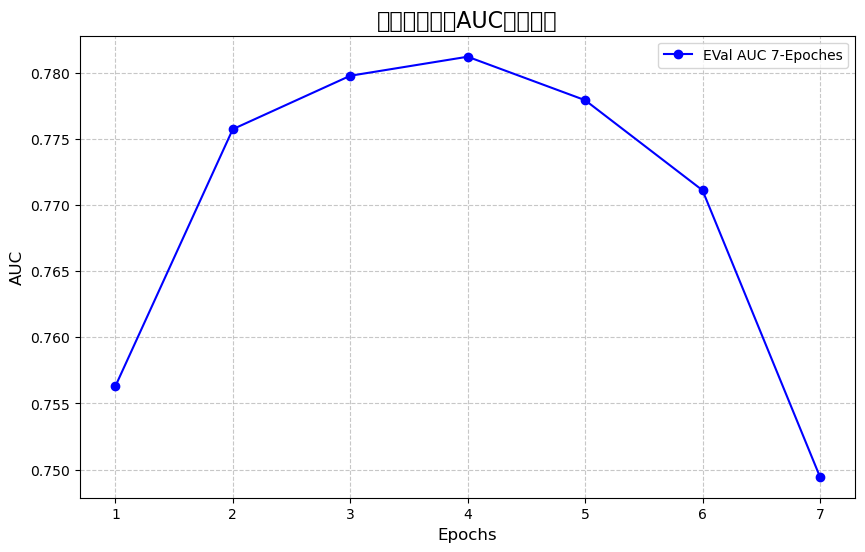

=== NN Fold 2 ===
276750
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7628,,,,,0.7628
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7730,,,,,0.7730
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7775,,,,,0.7775
保存的是第3轮的模型
Epoch 3: New best model saved with Val AUC: 0.7781,,,,,0.7781
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

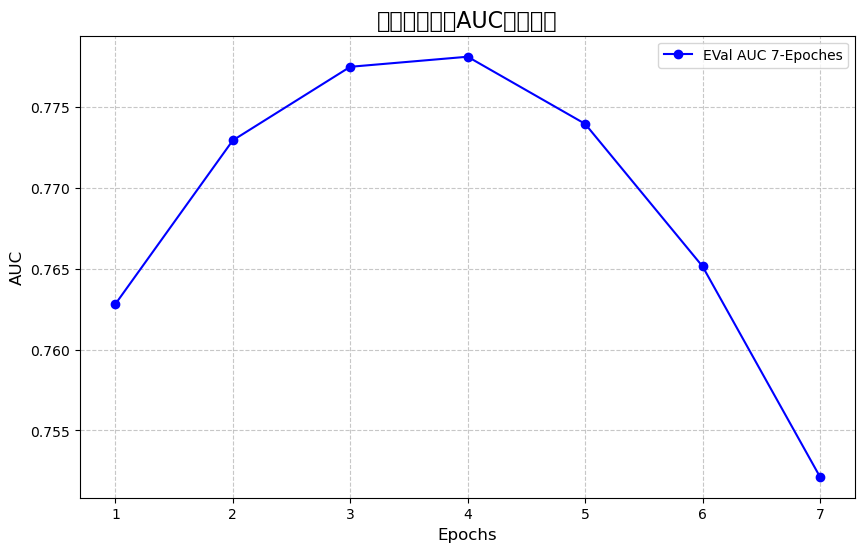

=== NN Fold 3 ===
276758
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7535,,,,,0.7535
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7677,,,,,0.7677
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7712,,,,,0.7712
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

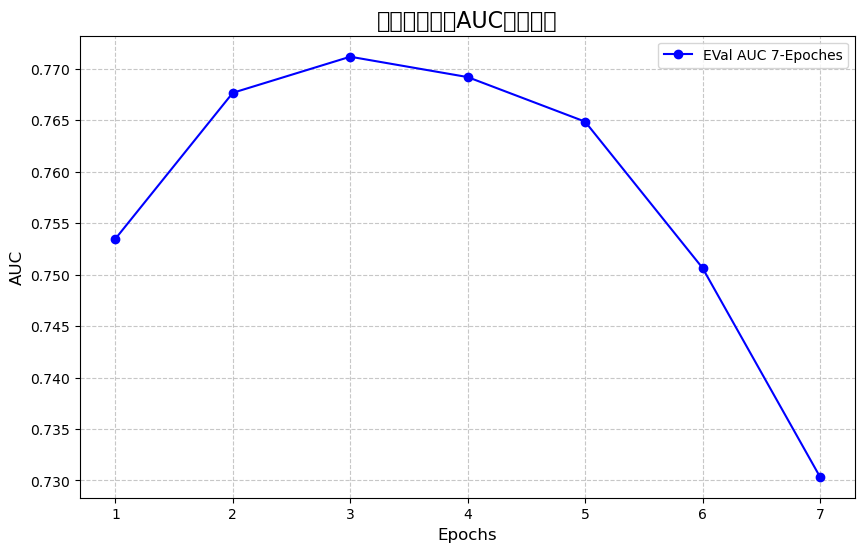

=== NN Fold 4 ===
276743
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7590,,,,,0.7590
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7717,,,,,0.7717
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7760,,,,,0.7760
保存的是第3轮的模型
Epoch 3: New best model saved with Val AUC: 0.7781,,,,,0.7781
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

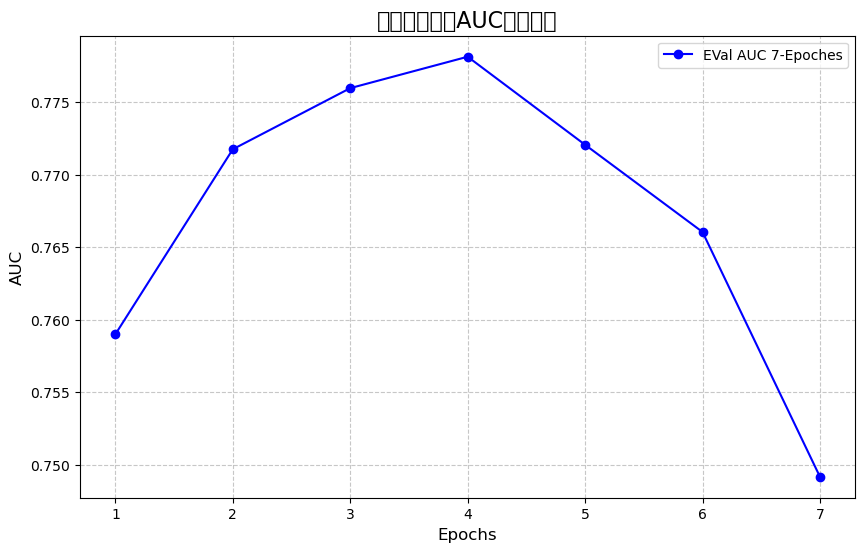

=== NN Fold 5 ===
276757
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7542,,,,,0.7542
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7703,,,,,0.7703
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7750,,,,,0.7750
保存的是第3轮的模型
Epoch 3: New best model saved with Val AUC: 0.7757,,,,,0.7757
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

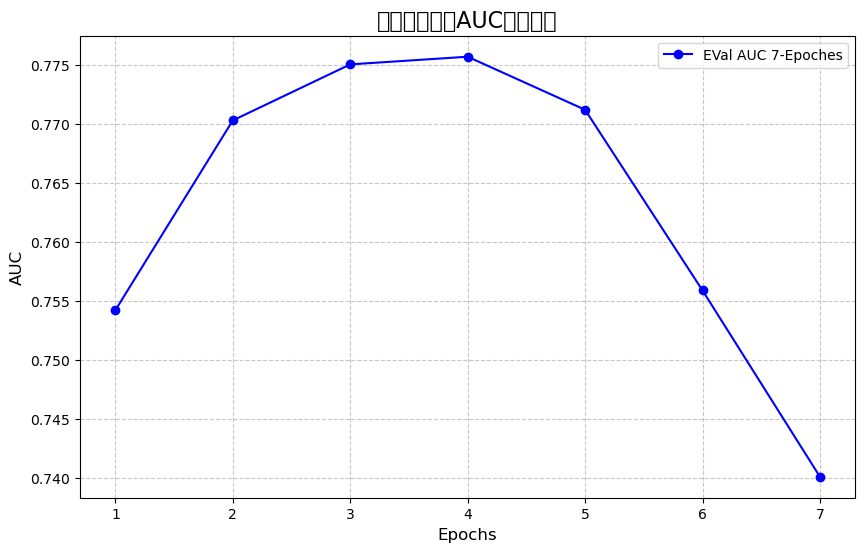

提取“验证集”上的潜在特征
   latent_0  latent_1   latent_2  latent_3  latent_4  latent_5  latent_6  \
0 -8.137432  1.580670  -3.716965 -0.112201 -0.370661 -1.231223 -0.359508   
1 -0.059572 -0.118951 -10.500507  2.395725  0.962803 -0.024413 -0.636997   
2 -0.100097 -0.260825 -11.037013  3.560872  1.527852 -0.009423 -0.751057   
3  0.512826 -3.961176  -4.817501 -0.214468  6.947526  0.177059  1.484882   
4  0.678951  0.057857   0.557956 -3.988652  2.768251 -0.202229  0.046044   

   latent_7  latent_8  latent_9  ...  latent_54  latent_55  latent_56  \
0  1.820698 -1.375370  0.465084  ...  -0.185138  -0.692692  -0.330903   
1 -0.193896 -4.297415  2.546601  ...   0.094514   0.784669  -0.045548   
2 -0.130421 -3.572010  1.979901  ...   0.045306   2.538832   0.147294   
3 -2.562370 -0.052999  0.039197  ...   3.907502  -0.022696  -0.109665   
4 -0.067627  0.715807 -0.907907  ...  -0.007047   2.205918   0.314293   

   latent_57  latent_58  latent_59  latent_60  latent_61  latent_62  latent_63  
0   0.899

In [ ]:
# 下面进行5折分层神经网络训练
from sklearn.model_selection import StratifiedKFold
kf=StratifiedKFold(n_splits=5,random_state=108,shuffle=True)
nn_folds=list(kf.split(x_train_numerical,y_train))

def train_NN_oof(x_train_numerical, x_train_cate_encoded, y_train,x_test_numerical,x_test_cate_encoded, y_test,folds):
    # 只有x_train_cate_encoded和x_test_cate_encoded是DataFrames的格式，其他的全为numpy.array格式
    if isinstance(y_train,pd.Series):
        y_train=y_train.values
    oof = np.zeros(len(y_train))
    oof_latents = np.zeros((len(y_train), 64), dtype=np.float32)   # 这里的64是要根据前面forward_classify的输出而定
    # 用于测试集的部分
    test_latents_all=np.zeros((len(x_test_numerical), 64), dtype=np.float32)
    preds_test = np.zeros(len(x_test_numerical))
     # 在最佳模型预测下进行
    y_test = y_test.astype('float32').reshape(-1, 1)  # 用于 BCE loss
    X_test_num_tensor = torch.tensor(x_test_numerical, dtype=torch.float32)
    X_test_cate_tensor= torch.tensor(x_test_cate_encoded[valid_categorical_cols].values,dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    test_dataset=TensorDataset(X_test_num_tensor,X_test_cate_tensor,y_test_tensor)         
    test_loader=DataLoader(test_dataset,batch_size=1024,shuffle=False)

    for fold, (train_idx, valid_idx) in enumerate(nn_folds):
        print(f"=== NN Fold {fold+1} ===")
        print(valid_idx.max()) 
        y_train_idx = y_train[train_idx].astype('float32').reshape(-1, 1)                # 用于 BCE loss..这样y_train就是[n_samples,1]
        X_train_num_tensor_idx = torch.tensor(x_train_numerical[train_idx], dtype=torch.float32)
        X_train_cate_tensor_idx = torch.tensor(x_train_cate_encoded[valid_categorical_cols].values[train_idx], dtype=torch.long)     # 嵌入层的输入对于分类特征必须是torch.long的格式
        y_train_tensor_idx = torch.tensor(y_train_idx, dtype=torch.float32)
        train_dataset_idx=TensorDataset(X_train_num_tensor_idx,X_train_cate_tensor_idx,y_train_tensor_idx)         
        train_loader_idx=DataLoader(train_dataset_idx,batch_size=1024,shuffle=True)


        y_val_idx = y_train[valid_idx].astype('float32').reshape(-1, 1)  # 用于 BCE loss
        X_val_num_tensor_idx = torch.tensor(x_train_numerical[valid_idx], dtype=torch.float32)
        X_val_cate_tensor_idx= torch.tensor(x_train_cate_encoded[valid_categorical_cols].values[valid_idx],dtype=torch.long)
        y_val_tensor_idx = torch.tensor(y_val_idx, dtype=torch.float32)
        val_dataset_idx=TensorDataset(X_val_num_tensor_idx,X_val_cate_tensor_idx,y_val_tensor_idx)         
        val_loader_idx=DataLoader(val_dataset_idx,batch_size=1024,shuffle=False)
        
        # 分类损失函数,使用BCEWithLogitsLoss函数  用于二分类（binary classification） 任务的损失计算。本质是 signmod函数和交叉熵损失函数的融合
        criterion = nn.BCEWithLogitsLoss() 
        # 如果不使用预训练的过程，需要在每一次epoch的时候都初始化model，这样可以避免泄露数据
        model=Tabular_Transformer(num_numerical=num_numerical_features,embed_dim=32,cate_dims_ls=cate_dims_ls,num_blocks=2,dropout=0.13 ,reduction_ratio=2,cross_layers=3,lower_rank=16)
    
        #print("加载预训练权重......")
        #model.load_state_dict(torch.load('pretrain_dae.pth'), strict=False)

        #使用预训练的过程进行初始化权重,这时候要把除了classifier_head的给锁住，也就是不能进行反向传播了
        # for name,param in model.named_parameters():
        #     if "classifier_head" not in name:
        #         param.requires_grad=False
        # first_optimizer=torch.optim.AdamW(filter(lambda x:x.requires_grad,model.parameters()),lr=1e-4)
        # model.train()
        # for X_num,X_cate,y in train_loader_idx:
        #     X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
        #     y_hat,_=model.forward_classify(X_cate,X_num)
        #     l=criterion(y_hat,y)   
        #     # 更新过程
        #     first_optimizer.zero_grad()
        #     l.backward()
        #     first_optimizer.step() #更新权重
        # print("预训练德过程结束后进行正式的训练，接下来寻找最优模型参数")

        #  这时候再正式开始训练，评估
        # for param in model.parameters():
        #     param.requires_grad = True
        finetune_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        best_model,eval_auc_epoches=train_epoches(model=model,train_loader=train_loader_idx,test_loader=val_loader_idx,device=device,loss=criterion,optimizer=finetune_optimizer,epoches=7)
        print("在验证集上的AUC变化过程")
        # 设置画布大小
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 8),eval_auc_epoches , marker='o', linestyle='-', color='b', label='EVal AUC 7-Epoches')
        # 添加标题和标签
        plt.title('在验证集上的AUC变化过程', fontsize=16)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('AUC', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()


        best_model.eval()
        val_preds_fold = []
        val_latents_fold = []
        best_model.load_state_dict(torch.load("best_model.pth"),strict=False)
        # 在验证集上的操作
        with torch.no_grad():
            for X_num, X_cate, _ in val_loader_idx:
                X_num, X_cate = X_num.to(device), X_cate.to(device)
                y_hat, latent_val = best_model.forward_classify(X_cate, X_num)
                val_preds_fold.append(torch.sigmoid(y_hat).cpu().numpy().flatten())
                val_latents_fold.append(latent_val.cpu().numpy())
        oof[valid_idx] = np.concatenate(val_preds_fold)
        oof_latents[valid_idx] = np.vstack(val_latents_fold)
         
        # 测试集（分batch处理）,应该每一次训练过都去预测测试集，最后的测试集特征是
        test_preds_fold=[]
        test_latents_fold=[]
        with torch.no_grad():
            for X_num,X_cate,y in test_loader:
                X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
                y_hat,latent_test=best_model.forward_classify(X_cate,X_num)
                test_preds_fold.append(torch.sigmoid(y_hat).cpu().numpy().flatten())  # flatten（）是用于把二维数组展平的操作  
                test_latents_fold.append(latent_test.cpu().numpy())
        test_latents_fold =np.vstack(test_latents_fold)
        test_preds_fold = np.concatenate(test_preds_fold)
        test_latents_all +=test_latents_fold/5
        preds_test += test_preds_fold/5   # 需要对numpy才可以这样直接除以5
    
    # 循环结束后的操作，保存结果
    preds_series=pd.Series(preds_test,index=x_test_cate_encoded.index,name="y_preds")
    preds_series.to_csv('nn_predictions.csv', header=True,index=False)
    oof_latents_df=pd.DataFrame(oof_latents,columns=[f"latent_{i}" for i in range(oof_latents.shape[1])])
    print("提取“验证集”上的潜在特征")
    oof_latents_df.to_csv("oof_latents_df.csv",index=False)
    print(oof_latents_df.head())
    test_latents_df=pd.DataFrame(test_latents_all,columns=[f"latent_{i}" for i in range(test_latents_all.shape[1])])
    print("提取“测试集”上的潜在特征")
    test_latents_df.to_csv("test_latents_df.csv",index=False)
    print(test_latents_df.head())
    return oof,preds_test,oof_latents,test_latents_all
nn_oof,nn_preds_test,latents_val,latents_test=train_NN_oof(x_train_numerical, x_train_cate_encoded, y_train,x_test_numerical,x_test_cate_encoded,y_test, nn_folds)


In [12]:
nn_preds_test=pd.read_csv("D:/Python_Projects/ML_Workspace/HCD_DefaultRisk/nn_predictions.csv")
nn_preds_test.head(2)

,Unnamed: 0,y_preds
0,260600,0.172070
1,90444,0.031488


In [17]:
nn_preds_test=nn_preds_test[["y_preds"]]
nn_preds_test.shape

(30752, 1)

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=y_test,y_score=nn_preds_test)

0.7868181194113676

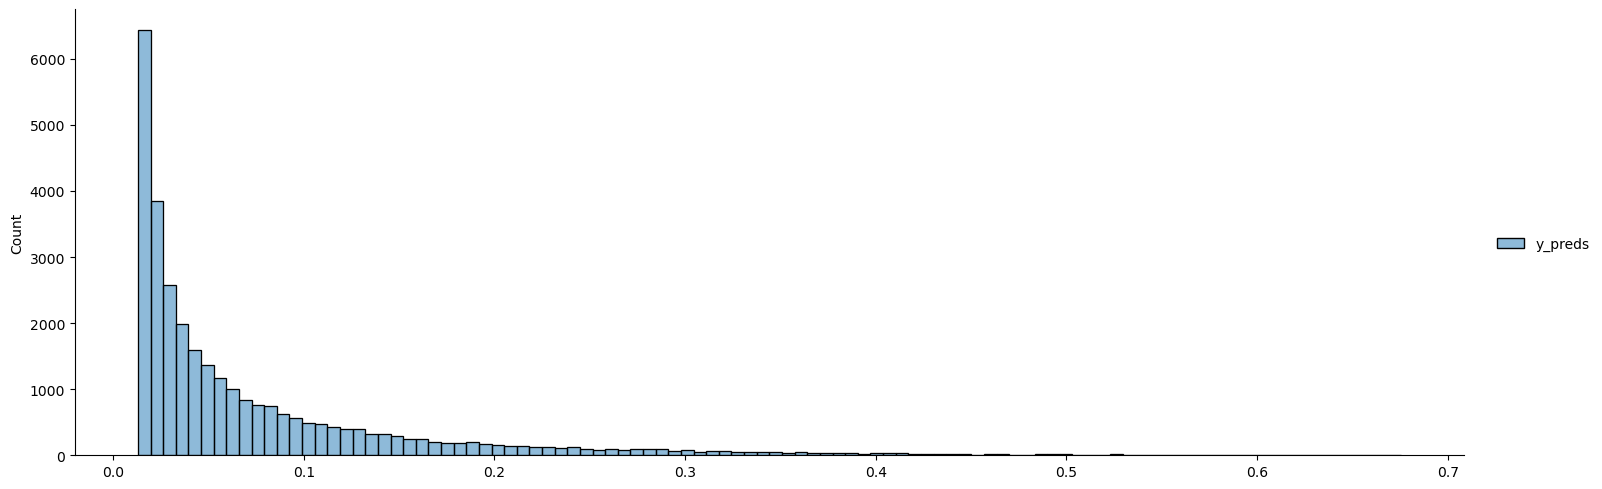

In [22]:
sns.displot(nn_preds_test,kde=False,bins=100, height=5,aspect=3)